# W207 Final Project: Baseline - TalkingData AdTracking Fraud Detection

**Team:** Samantha Williams, Vincent Goldberg and Heaven Klair


## **Introduction:** 
The [Kaggle competition](https://www.kaggle.com/competitions/talkingdata-adtracking-fraud-detection/overview) we have choosen was designed to find an algorithm for TalkingData that would best predict an app download after a mobile advertisement click is made. 

As China’s largest data service platform, TalkingData covers more than 70% of all active mobile devices and processes 3 billion clicks daily with an estimated 90% of those clicks considered fraudulent. 

This was TalkingData’s second Kaggle competition and provided users with a dataset with 200 million clicks over 4 days.

The problem that we are asked to solve is a predictive one: After clicking the ad with the user download the app? 


## **Step 1:** Import Libraries & Data

In [1]:
!pip install opendatasets --quiet
#!pip install dython #you will have to restart your session after installing dython if you’re using Colab.
#!pip install dask --quiet

In [2]:
# We will import every library needed for this project. 
import os

#importing data
#from dask import dataframe as dd
import opendatasets as od

#Data processing
import numpy as np
import pandas as pd
# from pandas.core.arrays.datetimes import time
# from dython.nominal import associations

#Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

#ML processing 
import tensorflow as tf 
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

We will import all the availble data sets directly from Kaggle using an API key generated through our Kaggle account. Additional details for accessing and downloading these data file can be found in the json file. 

In [38]:
#download the data sets from Kaggle directly 
#This will take approx 2 minutes and 10 seconds

#username: swllmsberkeley
#key: ea2c9237a51cd10c6ad36b17c9215c47

od.download(
    'https://www.kaggle.com/competitions/talkingdata-adtracking-fraud-detection/data?select=train_sample.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: swllmsberkeley
Your Kaggle Key: ··········


100%|██████████| 1.94G/1.94G [00:22<00:00, 93.4MB/s]



Extracting archive ./talkingdata-adtracking-fraud-detection/talkingdata-adtracking-fraud-detection.zip to ./talkingdata-adtracking-fraud-detection


While we would love to load in the full training and test set, we just do not have enough RAM to make this happen in one go. We will need to work with the data in batches. For our intial inspection of the data, we will be working with the training sample provided that contains 100,000 rows. 

### Loading Sample Training Set

Heaven set the types of data for the variables to int bc it is faster to separate the datasets into days with it.

In [3]:
#set the dtypes for the data set that we know based on the compeition details provided. 
#The following features are all categorical: ip, app, device, os and channel. 
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'click_time': 'str',
    'attributed_time': 'str',
    'is_attributed': 'uint8'
}


#read in the test data set 
test = pd.read_csv('/content/talkingdata-adtracking-fraud-detection/test.csv', dtype=dtypes)


In [4]:
test['click_time'] = pd.to_datetime(test['click_time'])
test['hour'] = test['click_time'].dt.hour 
test['day'] = test['click_time'].dt.day


###upload the final training sample that is balanced

In [5]:
train_sample_bal = pd.read_csv('/content/final_training_sample.csv')
train_sample_bal.info()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942229 entries, 0 to 942228
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       942229 non-null  int64 
 1   ip               942229 non-null  int64 
 2   app              942229 non-null  int64 
 3   device           942229 non-null  int64 
 4   os               942229 non-null  int64 
 5   channel          942229 non-null  int64 
 6   click_time       942229 non-null  object
 7   attributed_time  456846 non-null  object
 8   is_attributed    942229 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 64.7+ MB


## **Step 2:** Initial Inspection of Data

###Balanced Training Sample: Inspection and Adjustments of the Data

In [6]:
#Change click_time and attribuited_time from object to time
train_sample_bal['click_time'] = pd.to_datetime(train_sample_bal['click_time'])
train_sample_bal['attributed_time'] = pd.to_datetime(train_sample_bal['attributed_time'])

print('Sample Training Set:')
train_sample_bal.info()

Sample Training Set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942229 entries, 0 to 942228
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Unnamed: 0       942229 non-null  int64         
 1   ip               942229 non-null  int64         
 2   app              942229 non-null  int64         
 3   device           942229 non-null  int64         
 4   os               942229 non-null  int64         
 5   channel          942229 non-null  int64         
 6   click_time       942229 non-null  datetime64[ns]
 7   attributed_time  456846 non-null  datetime64[ns]
 8   is_attributed    942229 non-null  int64         
dtypes: datetime64[ns](2), int64(7)
memory usage: 64.7 MB


In [7]:
#checking the train sample table
train_sample_bal.head()

,Unnamed: 0,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,0,36183,12,1,3,245,2017-11-06 23:32:20,NaT,0
1,1,77792,15,1,17,265,2017-11-06 16:22:50,NaT,0
2,2,147957,9,1,19,232,2017-11-06 22:22:34,NaT,0
3,3,28082,15,1,19,245,2017-11-06 21:00:04,NaT,0
4,4,105128,12,1,13,245,2017-11-06 23:04:56,NaT,0


There are some NaT values in the attribuited time. Based on the explanation of this feature, it would imply that the person clicked on the ad but never downloaded the app. These are wherw would expect to find NaT values. Upon further analysis we have discovered that this is a fairly clean data set.  

In [11]:
#Looking for null values in places we do not expect
print(train_sample_bal.isnull().sum())

Unnamed: 0              0
ip                      0
app                     0
device                  0
os                      0
channel                 0
click_time              0
attributed_time    485383
is_attributed           0
dtype: int64


In [8]:
#Looking at descriptive statistics for the train sample data set
#Only 227 instances where the app was downloaded in the sample data set 
#there are 161 apps and 161 channels
#Only 34,857 unique ip address out of 100,000
  #Mulitple clicks on the link before download? 
#We have a heavily imbalanced data set 

train_sample_bal.describe(include='all', datetime_is_numeric=True)

,Unnamed: 0,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,942229.000000,942229.000000,942229.000000,942229.000000,942229.000000,942229.000000,942229,456846,942229.000000
mean,471114.000000,127246.482601,20.626887,26.985629,23.636161,238.181597,2017-11-08 06:25:15.271432192,2017-11-08 07:46:25.369995008,0.484857
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2017-11-06 15:41:07,2017-11-06 16:00:47,0.000000
25%,235557.000000,50169.000000,8.000000,1.000000,13.000000,130.000000,2017-11-07 11:17:23,2017-11-07 12:14:02,0.000000
50%,471114.000000,102800.000000,15.000000,1.000000,19.000000,213.000000,2017-11-08 06:42:14,2017-11-08 08:10:12,0.000000
75%,706671.000000,189972.000000,21.000000,1.000000,23.000000,330.000000,2017-11-09 02:21:22,2017-11-09 04:06:53.750000128,1.000000
max,942228.000000,364778.000000,768.000000,4223.000000,885.000000,498.000000,2017-11-09 16:00:00,2017-11-09 16:00:00,1.000000
std,271998.227732,96225.004645,27.056604,243.117935,55.653396,126.380464,NaN,NaN,0.499771


## **Step 3:** Visual Data Exploration

In [ ]:
#We should also look at the ip addresses
  #Are they all unique? 
  #Are there some key repeats (could they bots? Is this correctly tracked?)
  #how many ips have mulitple downloads? 
  #same ip: avg time between a click and download

#Should we look at the apps
  #Are some more popular than others?
  #whats the average time of download for each after clicking?

#How many Fraudulent vs Not Fraudulent clicks are there in the data? 
  #how many clicked the add but did not download? 

###Training Sample Visualizations

Visual explortation of the sample training set provided by TalkingData. 

####Histogram of Click Times

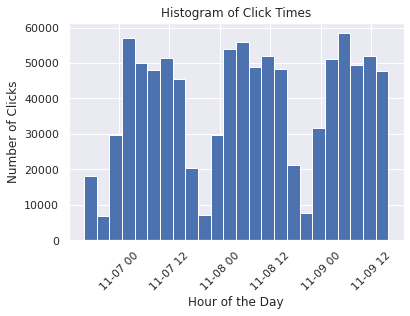

In [9]:
plt.hist(train_sample_bal['click_time'], bins=24)
plt.xlabel('Hour of the Day') #is this in military time? HH:MM:SS?
plt.ylabel('Number of Clicks')
plt.title('Histogram of Click Times')
plt.xticks(rotation=45) 
plt.show()

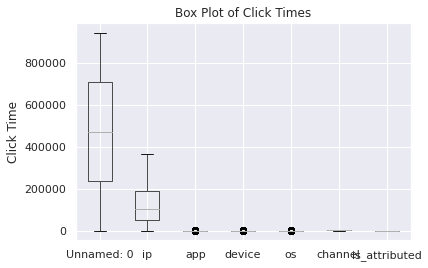

In [10]:
#this will not work because the data is categorical 
# Plot a boxplot of the click time for all variables (this doesn't seem right. Need more investigation)
train_sample_bal.boxplot()
plt.title('Box Plot of Click Times')
plt.ylabel('Click Time')

plt.show()

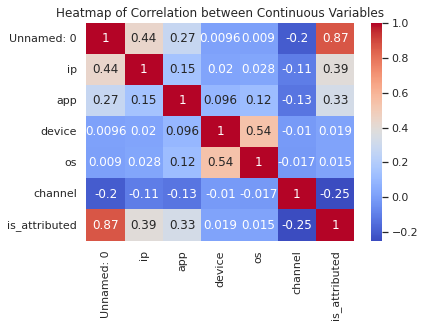

In [11]:
#corr Matrix - This will not work becuase the data is catagorical 
#chi-squared? 
corr = train_sample_bal.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Heatmap of Correlation between Continuous Variables')
plt.show()

**Heaven's takeway from the corr matrix:** All the values are pretty small except from correlation between `os` and `device` which makes sense since an operating system of a device is highly dependent upon the device a person is using. If we were to do feature engineering, we can drop one of these variables. Decide upon discussion. 

In [ ]:
#these are categorical 
sns.pairplot(train_sample_bal[['click_time', 'app', 'device', 'os', 'channel', 'ip']])
plt.title('Pair Plot of Click Time, App, Device, OS, Channel, and IP')
plt.show()

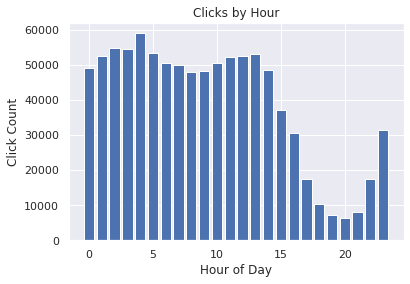

In [13]:
# Extract hour and day information from click_time (inclusive of all 4 days)
# We can do the same for each day as well (haven't written the code yet)
train_sample_bal['hour'] = train_sample_bal['click_time'].dt.hour 
train_sample_bal['day'] = train_sample_bal['click_time'].dt.day

# Plot the distribution of clicks by hour
hour_counts = train_sample_bal['hour'].value_counts().sort_index()
plt.bar(hour_counts.index, hour_counts.values)
plt.xlabel('Hour of Day')
plt.ylabel('Click Count')
plt.title('Clicks by Hour')
plt.show()

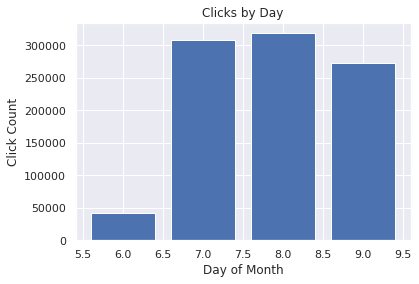

In [14]:
# Plot the distribution of clicks by day (there are only 4 days)
day_counts = train_sample_bal['day'].value_counts().sort_index()
plt.bar(day_counts.index, day_counts.values)
plt.xlabel('Day of Month')
plt.ylabel('Click Count')
plt.title('Clicks by Day')
plt.show()

In [15]:
def boxplot_figures(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


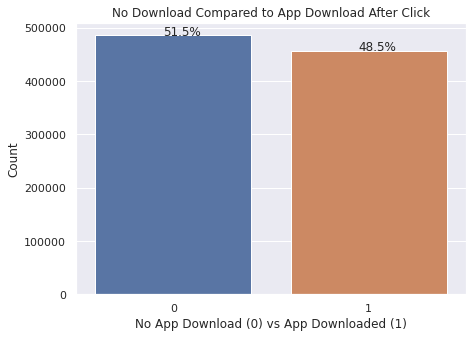

In [16]:
plt.figure(figsize= (7,5))
ax =sns.countplot('is_attributed', data = train_sample_bal)
plt.title('No Download Compared to App Download After Click')
plt.xlabel('No App Download (0) vs App Downloaded (1)')
plt.ylabel('Count')

boxplot_figures(ax, train_sample_bal.is_attributed)

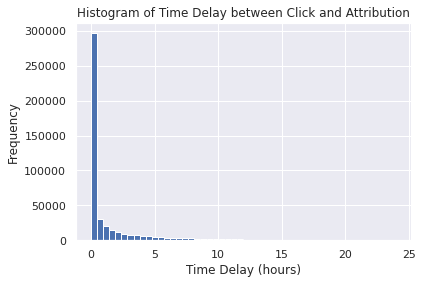

In [17]:
# Code might not run until the train_sample dataset is not loaded
# calculate the time elapsed between click and attribution, in hours
time_delay = (train_sample_bal['attributed_time'] - train_sample_bal['click_time']).dt.total_seconds() / 3600

# create a histogram of the time delay
plt.hist(time_delay, bins=50)

# add labels and title
plt.xlabel('Time Delay (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Delay between Click and Attribution')

# display the plot
plt.show()


# Random Forest Classifer 

In [18]:
train_sample_bal['sec_till_dl'] = (train_sample_bal['attributed_time'] - train_sample_bal['click_time']).dt.total_seconds() / 3600

In [19]:
train_sample_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942229 entries, 0 to 942228
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Unnamed: 0       942229 non-null  int64         
 1   ip               942229 non-null  int64         
 2   app              942229 non-null  int64         
 3   device           942229 non-null  int64         
 4   os               942229 non-null  int64         
 5   channel          942229 non-null  int64         
 6   click_time       942229 non-null  datetime64[ns]
 7   attributed_time  456846 non-null  datetime64[ns]
 8   is_attributed    942229 non-null  int64         
 9   hour             942229 non-null  int64         
 10  day              942229 non-null  int64         
 11  sec_till_dl      456846 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(9)
memory usage: 86.3 MB


In [22]:
import time
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

In [24]:
#prepare training data, remove unused fields & features that we will not one hot encode 
rf_train_x = train_sample_bal.drop(['ip', 'is_attributed', 'click_time', 'attributed_time', 'Unnamed: 0', 'sec_till_dl'], axis=1)
rf_train_y = train_sample_bal['is_attributed']
rf_test = test.drop(['click_id', 'click_time','ip'], axis=1)

rf_train_x_ip = train_sample_bal['ip']
rf_test_cd = test['click_id']

In [26]:
rf_train_x['sec_till_dl'] = rf_train_x['sec_till_dl'].replace(np.nan, 0)

In [23]:
# one hot encoding categorial features
enc = OneHotEncoder(handle_unknown='ignore')
rf_train_xenc = enc.fit_transform(rf_train_x)
rf_test_enc = enc.fit_transform(rf_test)

In [29]:
rf_test_enc = pd.merge(rf_test_enc, rf_test_cd[["click_id"]], on=[0], how="left")

KeyError: ignored

In [55]:
#n_estimators default is 10 
#max_depth default = None, set this to a random number of 5
#min_samples_leaf default=1, set this to be 100
#max_features default = sqrt
#bootstrap default=True, set to false so entire data set used
#n_jobsint, default=None but documentation says none =1, set to -1 based on link: https://scikit-learn.org/stable/glossary.html#term-n_jobs
#random_state=123 to replicate our findings

rf_model = RandomForestClassifier(max_depth=5, min_samples_leaf=100, bootstrap=False, n_jobs=-1, random_state=123)
%time rf_model.fit(rf_train_xenc, rf_train_y)

CPU times: user 19.6 s, sys: 116 ms, total: 19.7 s
Wall time: 10.6 s


RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=100,
                       n_jobs=-1, random_state=123)

In [56]:
#make predictions on the test set
rf_pred_test = rf_model.predict(rf_test_enc)

ValueError: ignored

In [37]:
confusion_matrix(rf_test, rf_pred_test)

ValueError: ignored

## **Step 4:** Feature Engineering 

Change all NANs to 1 or 0

number of clicks on ad before download (groupby: ip, device, chan, os)

Hour of the day


## **Step 5:** Baseline Model

Although the final test data set consist of values indicating the probability a user will download an app, the train data set uses a binary classifier to indicate whether a user downloaded the app. A value of 1 is assigned to the clicks that led to a download, while a value of 0 indicates a click did not lead to a download. Due to the nature of the binary classification, a logistic regression model was selected to be the baseline model evaluation. 

## **Step 6:** Train and Evaluate Model

## **Step 7:** Thoughts and Next Steps